In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import shapely
import plotly.express as px
from datetime import datetime
import math

pd.options.mode.chained_assignment = None  # default='warn'

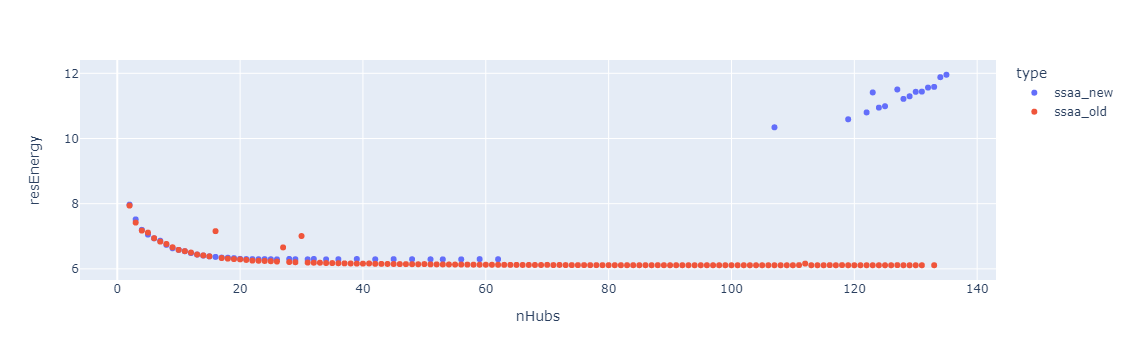

In [15]:
# read resEnergy for both random  
reRandom = pd.read_csv('results/resEnergy_random_all.csv')
reRandom = reRandom[['nHubs', 'resEnergy', 'type']]

# read resEnergy for new and old  
def readResEnergy(fileName, extension): 
    cols = ['index', 'resEnergy', 'nHubs', 'startTime', 'endTime']
    reFile = pd.read_csv(fileName, header=None, names=cols) # fileName = 'results/resEnergy_230328_2-138.csv'
    temp = reFile.copy()
    temp = temp.groupby('nHubs').min().resEnergy.reset_index()
    temp['type'] = 'ssaa_{}'.format(extension)
    return temp
reNew = readResEnergy('results/resEnergy_230328_2-138.csv', 'new')
reOldDfs = []
for hubRange in ['2-50', '51-80', '81-110', '111-138']: 
    temp = readResEnergy('results/resEnergy_parallel_{}.csv'.format(hubRange), 'old_{}'.format(hubRange))
    reOldDfs.append(temp)
reOld = pd.concat(reOldDfs)
reOld.type = 'ssaa_old'
reOld.to_csv('results/resEnergy_230324_all.csv')

reBoth = pd.concat([reNew, reOld])
px.scatter(reBoth, x='nHubs', y='resEnergy', color='type')

In [33]:
def readResPoints(fileName, extension): 
    cols = ['index', 'hubName', 'x', 'y', 'nHubs', 'startTime', 'endTime']
    rpFile = pd.read_csv(fileName, header=None, names=cols)
    rpNew = rpFile.copy()
    rpNew = rpNew[['hubName', 'x', 'y', 'nHubs']]
    rpNew.hubName = rpNew.hubName - 1
    rpNew = gpd.GeoDataFrame(rpNew, geometry = gpd.points_from_xy(rpNew.x, rpNew.y), crs='EPSG:28992')
    rpNew['type'] = extension
    return rpNew

rpNew = readResPoints('results/resPoints_230328_2-138.csv', 'ssaa_new')

rpOldDfs = []
for hubRange in ['2-50', '51-80', '81-110', '111-138']: 
    temp = readResPoints('results/resPoints_parallel_{}.csv'.format(hubRange), 'ssaa_old')
    rpOldDfs.append(temp)
rpOld = pd.concat(rpOldDfs)

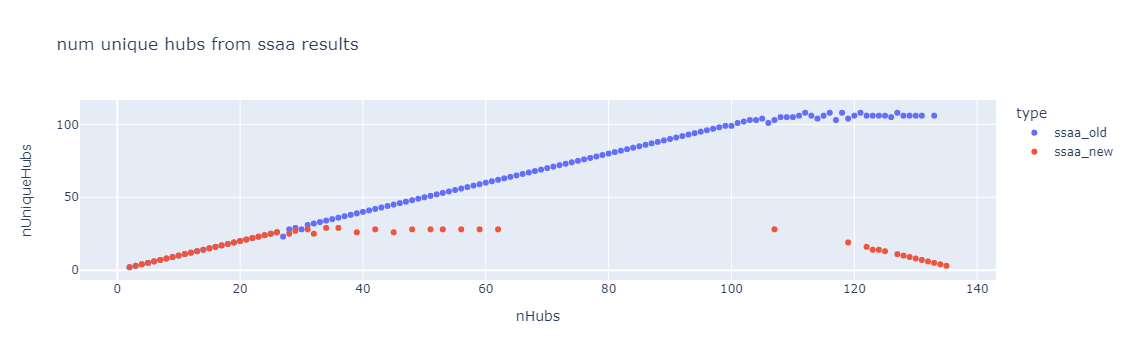

In [62]:
def countUniqueHubs(nHubs, rpDf): 
    nUniqueHubs = len(rpDf[rpDf.nHubs == nHubs].hubName.unique())
    if nUniqueHubs > nHubs: 
        nUniqueHubs = nHubs
    return nUniqueHubs

reOld['nUniqueHubs'] = reOld.nHubs.map(lambda nHubs: countUniqueHubs(nHubs, rpOld))
reNew['nUniqueHubs'] = reNew.nHubs.map(lambda nHubs: countUniqueHubs(nHubs, rpNew))
reBoth = pd.concat([reOld, reNew])

px.scatter(reBoth, x='nHubs', y='nUniqueHubs', color='type', title='num unique hubs from ssaa results')

In [82]:
candiHubs = gpd.read_file('data/candiHubs_ams.shp')
matGrid = gpd.read_file('data/matGrid_ams.shp')

<AxesSubplot: >

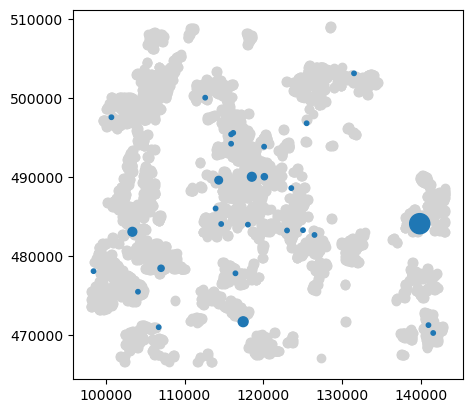

In [88]:
nHubs = 62
rpTest = rpNew[rpNew.nHubs == nHubs]
rpTest = rpTest.groupby('hubName').count().x.reset_index()
rpTest.rename(columns={'x': 'hubCount'}, inplace=True)
rpTest = pd.merge(rpTest, candiHubs, on='hubName')
rpTest = gpd.GeoDataFrame(rpTest)
ax = matGrid.plot(color='lightgrey')
rpTest.plot(markersize=rpTest.hubCount*10, ax=ax)

In [ ]:
rpTest.head()

,hubName,hubCount,RIN_NUMMER,MAX_MILIEU,pPerSqm,geometry
0,10,21,215031,3,291.971767,POINT (139818.183 484096.441)
1,11,5,262019003,3,288.198390,POINT (117432.643 471666.113)
2,21,4,1583,3,189.009620,POINT (103386.486 483071.121)
3,23,3,1478,3,236.914362,POINT (114331.587 489612.144)
4,25,4,27201036,3,252.066723,POINT (118529.541 490045.490)


In [94]:
rpNew[rpNew.nHubs == 62].sort_values('hubName')

,hubName,x,y,nHubs,geometry,type
1104,10,139818.239553,484096.491091,62,POINT (139818.240 484096.491),ssaa_new
1163,10,139818.203328,484098.887209,62,POINT (139818.203 484098.887),ssaa_new
1162,10,139818.234402,484096.735577,62,POINT (139818.234 484096.736),ssaa_new
1161,10,139818.210882,484098.681489,62,POINT (139818.211 484098.681),ssaa_new
1157,10,139818.218088,484094.445987,62,POINT (139818.218 484094.446),ssaa_new
...,...,...,...,...,...,...
1137,108,126475.150261,482670.459779,62,POINT (126475.150 482670.460),ssaa_new
1115,109,116454.163716,477802.470641,62,POINT (116454.164 477802.471),ssaa_new
1154,114,122994.735777,483237.807684,62,POINT (122994.736 483237.808),ssaa_new
1106,128,98460.995794,478079.813353,62,POINT (98460.996 478079.813),ssaa_new


In [101]:
# ran ssaa for nHubs=32 at low temperatures
reTest = pd.read_csv('results/resEnergy_230329_test.csv', header=None, names=['index', 'resEnergy', 'nHubs', 'timeStamp'])
rpTest = pd.read_csv('results/resPoints_230329_test.csv', header=None, names=['index', 'hubName', 'x', 'y', 'nHubs', 'timeStamp'])
rpTest.hubName = rpTest.hubName - 1
len(rpTest.hubName.unique())

29

# backup

## 230327 - Adjusting storage cost to reflect redundancies

In [2]:
def assignHubsToGridCells(hubs, matGrid, distMatrix): 
    def findHub(matGrid_index): 
        hubs_index = [int(x) for x in list(hubs.hubName)]
        dists = distMatrix[matGrid_index, hubs_index]
        idxmin = np.argmin(dists)
        chosenHub = hubs_index[idxmin]
        return chosenHub
    matGrid['hubName'] = matGrid.index.map(lambda x: findHub(x))
    
    # formatting 
    matGrid = matGrid[['kgDemand', 'kgSupply', 'hubName', 'geometry']]
    
    return matGrid 

In [3]:
matGrid = gpd.read_file('data/matGrid_ams.shp')
candiHubs = gpd.read_file('data/candiHubs_ams.shp') 
distMatrix = np.load('data/costMatrix_ams.npy')

In [4]:
from costEffectiveness_v2 import calcTotStorageCost

In [6]:
hubs = candiHubs.sample(139)
matGridAss = assignHubsToGridCells(hubs, matGrid, distMatrix)
hubs, sc = calcTotStorageCost_original(hubs, matGridAss, candiHubs)

In [21]:
lenZeroHubs = len(hubs[hubs.m2 == 0])
hubs[(hubs.m2 > 0) & (hubs.m2 < 50)]

,RIN_NUMMER,MAX_MILIEU,pPerSqm,hubName,geometry,m2,storagePrice,storageCost
87,706173,3,240.898715,87,POINT (112618.668 500073.540),11.101124,490.898715,5449.527403
131,170402,3,295.978862,131,POINT (102716.133 468813.293),18.647601,545.978862,10181.196041
38,707023,3,241.933527,38,POINT (128446.318 493852.859),2.131576,491.933527,1048.593743
14,827104,3,244.574386,14,POINT (112619.596 485883.500),1.511847,494.574386,747.720926
58,1422,3,308.967376,58,POINT (117548.877 477554.342),15.204404,558.967376,8498.765552
...,...,...,...,...,...,...,...,...
41,160008,3,257.195438,41,POINT (113935.641 486024.248),37.215436,507.195438,18875.499343
23,1478,3,236.914362,23,POINT (114331.587 489612.144),31.417537,486.914362,15297.649784
20,1393,3,295.657641,20,POINT (113217.639 474647.127),4.342623,545.657641,2369.585570
50,827109,2,284.454371,50,POINT (127047.773 486205.547),36.333592,534.454371,19418.646939


<AxesSubplot: >

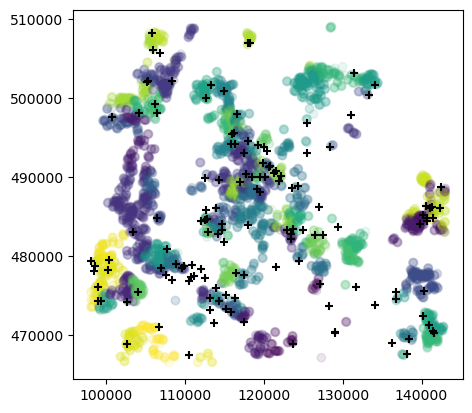

In [12]:
ax = matGridAss.plot(column='hubName', alpha=0.1)
hubs.plot(ax=ax, color='black', marker='+')

In [107]:
storageCostDict = {}
for nHubs in range(1, 139): 
    print(nHubs)
    hubs = candiHubs.sample(nHubs)
    matGridAss = assignHubsToGridCells(hubs, matGrid, distMatrix)
    sc = calcTotStorageCost(hubs, matGridAss, candiHubs)
    hubs, sc_modified = calcTotStorageCost_modified(hubs, matGridAss, candiHubs)
    storageCostDict[nHubs] = [sc, sc_modified]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138


In [109]:
storageCosts = np.array(list(storageCostDict.values()))

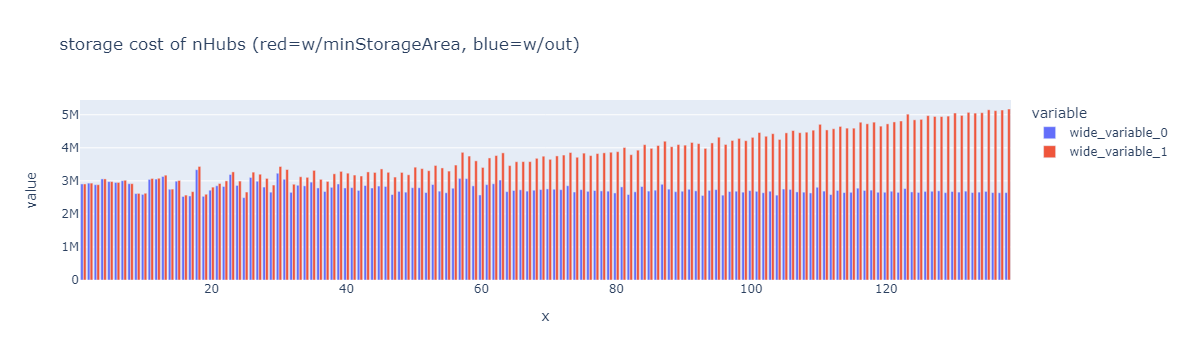

In [116]:
px.bar(x=storageCostDict.keys(), y=[storageCosts[:, 0], storageCosts[:, 1]], barmode='group', title='storage cost of nHubs (red=w/minStorageArea, blue=w/out)')

In [5]:
def calcTotStorageCost_original(hubs, matGridAss, candiHubs): 
    
    def calcm2storage(row): 
        hubName = row.hubName 
        # print('\nhubName: {}'.format(hubName))

        # calculate material stored in hub in kg
        clients = matGridAss[matGridAss.hubName == hubName]
        kgSupply = clients.kgSupply.sum()
        kgDemand = clients.kgDemand.sum()
        kgStored = kgSupply if kgDemand > kgSupply else kgDemand 

        # calculate kgStored assuming throughput 
        storageMonths = 1 # previously 6 months
        studyPeriodMonths = 5 * 12 # 5 years 
        percStorageMonths = storageMonths / studyPeriodMonths * 100 
        kgStored = kgStored * percStorageMonths / 100

        # calculate storage area required
        avTimberDensity = 510 # see CO2 opslag rekening tool
        avStorageHeight = 3.5 # meters 
        kgStoredPerM2 = avTimberDensity * 0.8 * avStorageHeight
        m2storage = kgStored / kgStoredPerM2

        # calculate storate area required + logistics space 
        percAreaLogistics = 30
        percAreaStorage = 100 - percAreaLogistics
        m2storage = m2storage / percAreaStorage * 100
        mStorageWidth = math.sqrt(m2storage)
        
        # min storage area - was not in original
        # minStorageArea = 50
        # if m2storage < minStorageArea: 
        #     m2storage = minStorageArea
        
        return m2storage
    
    def calcStoragePrice(row): 
        # calculate land and building price
        landPrice = row.pPerSqm
        buildingPrice = 250 # euros per sqm 
        totalPrice = landPrice + buildingPrice # euros per sqm 
        
        return totalPrice

    # calculate storage cost for one hub
    def calcStorageCost(row): 

        # calculate final storage cost 
        storageCost = totalPrice * m2storage
        if m2storage == 0: 
            storageCost = totalPrice * 100

        return storageCost
    
    # sum storage cost for all hubs
    hubs['m2'] = hubs.apply(lambda row: calcm2storage(row), axis=1)
    hubs['storagePrice'] = hubs.apply(lambda row: calcStoragePrice(row), axis=1)
    hubs['storageCost'] = hubs.m2 * hubs.storagePrice
    totStorageCost = hubs.storageCost.sum()
    
    return hubs, totStorageCost